In [1]:
import pandas as pd 
import numpy as np
import pickle

In [2]:
temp = pd.read_pickle('temp.pkl')
pd.set_option('display.max_colwidth',1000)
temp.reset_index(drop = True, inplace = True)
temp.head()

,country,points,price,province,variety,text
0,Portugal,87,15.0,Douro,Portuguese Red,ripe fruity wine smooth still structured firm tannins filled juicy red berry fruits freshened acidity already drinkable although certainly better two thousand and sixteen quinta dos avidagos two thousand and eleven avidagos red douro
1,US,87,14.0,Oregon,Pinot Gris,tart snappy flavors lime flesh rind dominate green pineapple pokes crisp acidity underscoring flavors wine stainlesssteel fermented rainstorm two thousand and thirteen pinot gris willamette valley
2,US,87,13.0,Michigan,Riesling,pineapple rind lemon pith orange blossom start aromas palate bit opulent notes honeydrizzled guava mango giving way slightly astringent semidry finish st julian two thousand and thirteen reserve late harvest riesling lake michigan shore
3,US,87,65.0,Oregon,Pinot Noir,much like regular bottling two thousand and twelve comes across rather rough tannic rustic earthy herbal characteristics nonetheless think pleasantly unfussy country wine good companion hearty winter stew sweet cheeks two thousand and twelve vintner reserve wild child block pinot noir willamette valley
4,France,87,24.0,Alsace,Gewürztraminer,dry restrained wine offers spice profusion balanced acidity firm texture much food trimbach two thousand and twelve gewurztraminer alsace


## TF-IDF VECTORIZER:
In order to extract features from our text column we shall be using a technique called TF-IDF [Term Frequency - Inverse Document Frequency] Vectorizing. This invloves two components

- Term Frequency: This summarizes how often a given word appears within a document.

- Inverse Document Frequency: This downscales words that appear a lot across documents.

This technique is chosen due to the fact that simple count vectorizer counts the number of times a word occurs in a document but words like "the" occurs more frequently than one can imagine in a document, yet it contains not much information to the model. Hence these frequencies are encoded in a reverse order.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
cv=TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')
#transformed train reviews
cv_text=cv.fit_transform(temp.text)

print('BOW_cv_text:',cv_text.shape)

BOW_cv_text: (96324, 55007)


In [5]:
temp.nunique()

country        40
points         21
price         366
province      363
variety        28
text        88909
dtype: int64

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
#Scaling the numerical columns to the range of (0-1)
scaler = MinMaxScaler()
temp[['points','price']] = scaler.fit_transform(temp[['points','price']])

In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
#One Hot Encoding categorical Features
le = OneHotEncoder(handle_unknown = 'ignore')
enc = le.fit_transform(temp[['country','province']])
enc.shape

(96324, 403)

In [10]:
Y = temp['variety']
import scipy.sparse as sp
X = sp.hstack((cv_text,enc,temp[['points','price']].values))
X.shape

(96324, 55412)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train,x_test,y_train,y_test = train_test_split(X , Y, stratify = Y) 
#We stratify on Y to equally distribute categorical features into train and test

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(Y)

### Random forest classfier model

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
%%time
rf = RandomForestClassifier( class_weight= 'balanced', n_jobs = -1)
rf.fit(x_train,y_train)

CPU times: total: 1h 11min 9s
Wall time: 23min 36s


RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [16]:
pred = rf.predict(x_test)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def confusion(actual,predicted):
  results = confusion_matrix(actual, predicted) 
  
  print ('Confusion Matrix :')
  print(results) 
  print ('Accuracy Score :',accuracy_score(actual, predicted) )
  print ('Report : ')
  print (classification_report(actual, predicted) )
  return results

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,6), fontsize=14):
  df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
  fig = plt.figure(figsize=(15,15))
  try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  return fig

In [20]:
res = confusion(y_test,pred)

Confusion Matrix :
[[1070    0    0   97    0    0    0    0    0    2    3    0    0    0
     7    0    0  150    0    0    1    0    1    0    3    0    0    1]
 [  36  125    0    0    0    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   10    0    0    0    0    0]
 [   4    0  240   57    0    0    0    0    0    3    1    0    0    0
     6    0    0    7    0    0    3    0    3    1    0    0    0    1]
 [   8    0    0 2320    0    1    0    0    0    0    0    0    0    0
     0    2    0   15    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0  262    8    0    0    0    0    0    0    0    0
     3    0    0    0    0    0    2    0    0   28    0    0    0    0]
 [   0    0    0    0   12 2729    1    0    0    1    0    0    0    0
     1    1    0    0    0    2    0    0   11    8    0    0    3    0]
 [   0    0    0    0    0    3  202    0    0    0    0    0    0    0
     3    0    0    0    0    0    0   

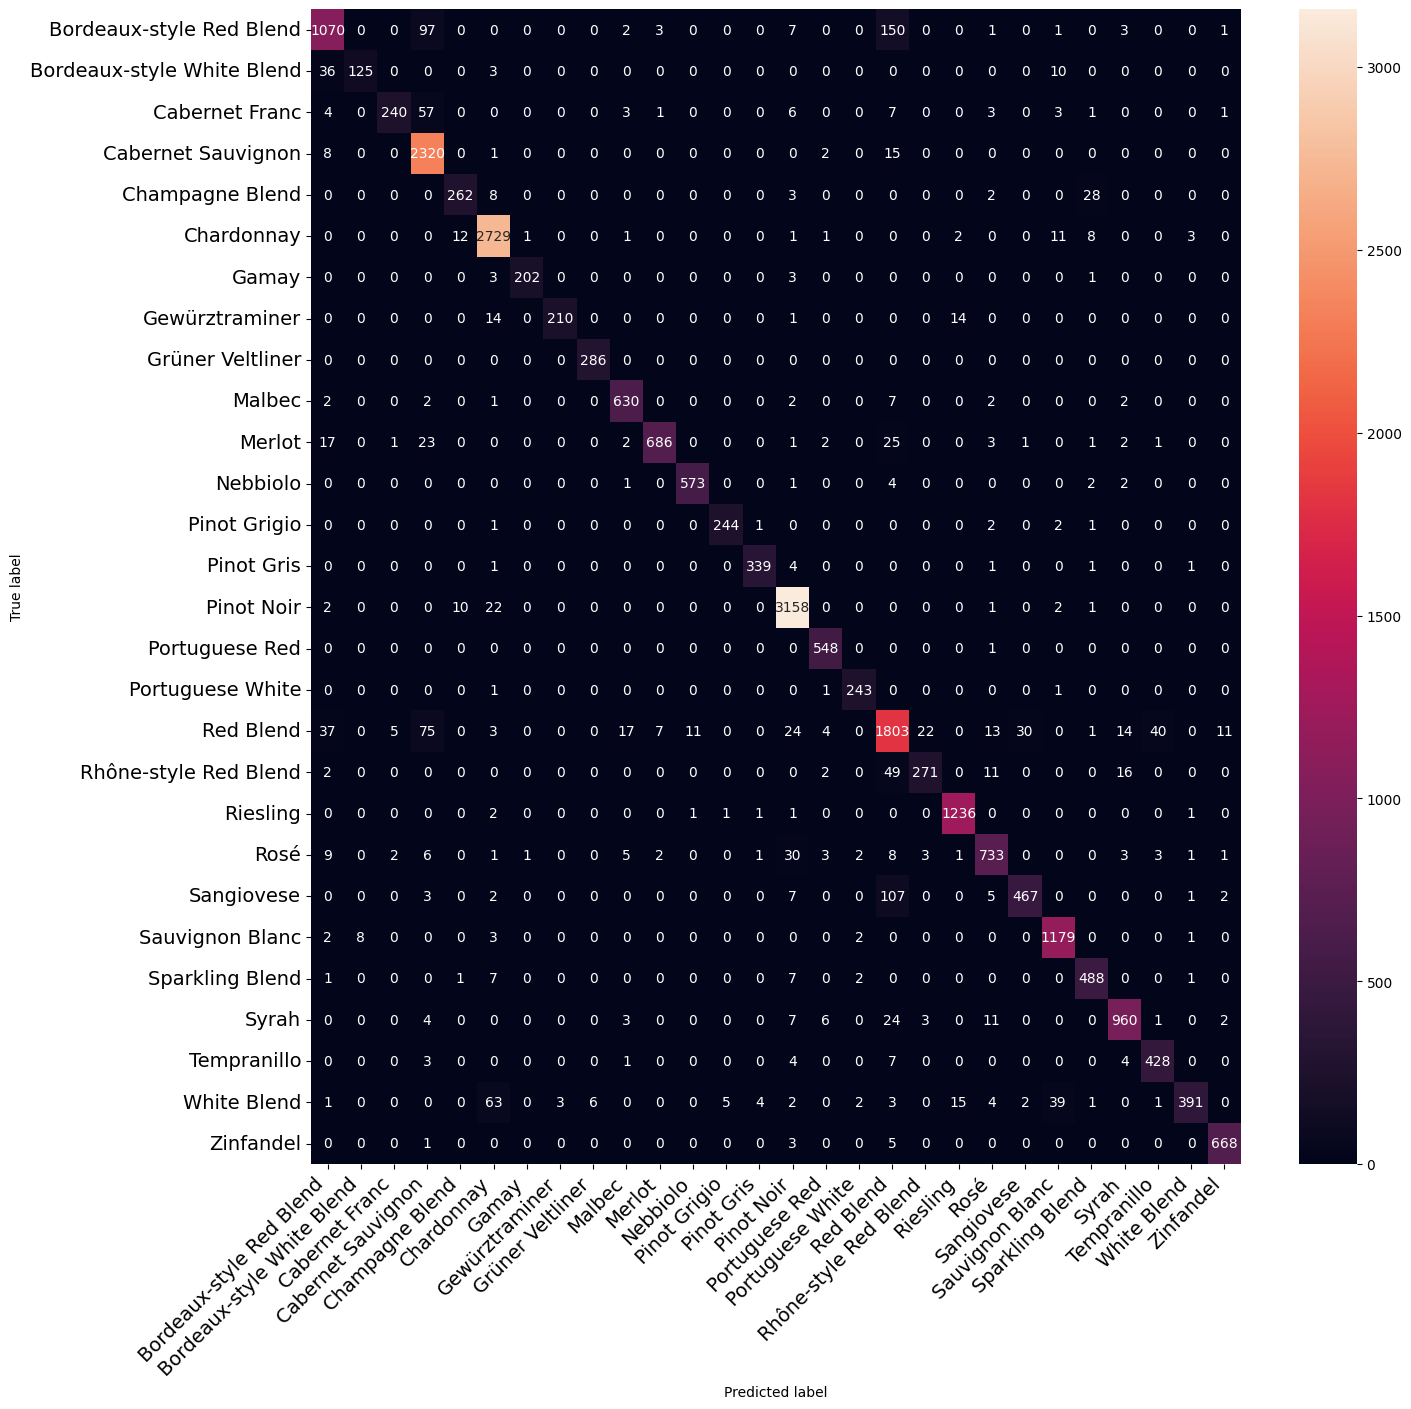

In [21]:
print_confusion_matrix(res, np.unique(Y));

Observed Validation Accuracy: 93%

XGBoost

In [23]:
import xgboost as xgb

In [24]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()

In [27]:
y_train = label_encoder.fit_transform(y_train)

In [28]:
%%time
clf.fit(x_train,y_train)

CPU times: total: 59min 31s
Wall time: 25min 29s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [29]:
pred = clf.predict(x_test)

In [33]:
y_test = label_encoder.fit_transform(y_test)

In [34]:
res = confusion(y_test,pred)

Confusion Matrix :
[[1204    2    0   10    0    0    0    0    0    1    8    0    0    0
     0    0    0  105    1    0    4    0    0    0    0    0    0    0]
 [  10  154    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    1    0    3    0    0    0    6    0]
 [   1    0  317    2    0    0    0    0    0    1    1    0    0    0
     0    0    0    1    0    0    3    0    0    0    0    0    0    0]
 [  13    0    1 2318    0    0    0    0    0    0    5    0    0    0
     0    0    0    7    0    0    2    0    0    0    0    0    0    0]
 [   0    1    0    0  281    2    0    0    0    0    0    0    0    0
     4    0    0    0    0    0    2    0    0   10    0    0    3    0]
 [   0    0    0    0    6 2745    0    0    0    0    0    0    0    0
     1    0    0    0    0    1    0    0    4    6    0    0    6    0]
 [   0    0    0    0    0    0  204    0    0    0    0    0    0    0
     1    0    0    3    0    0    0   

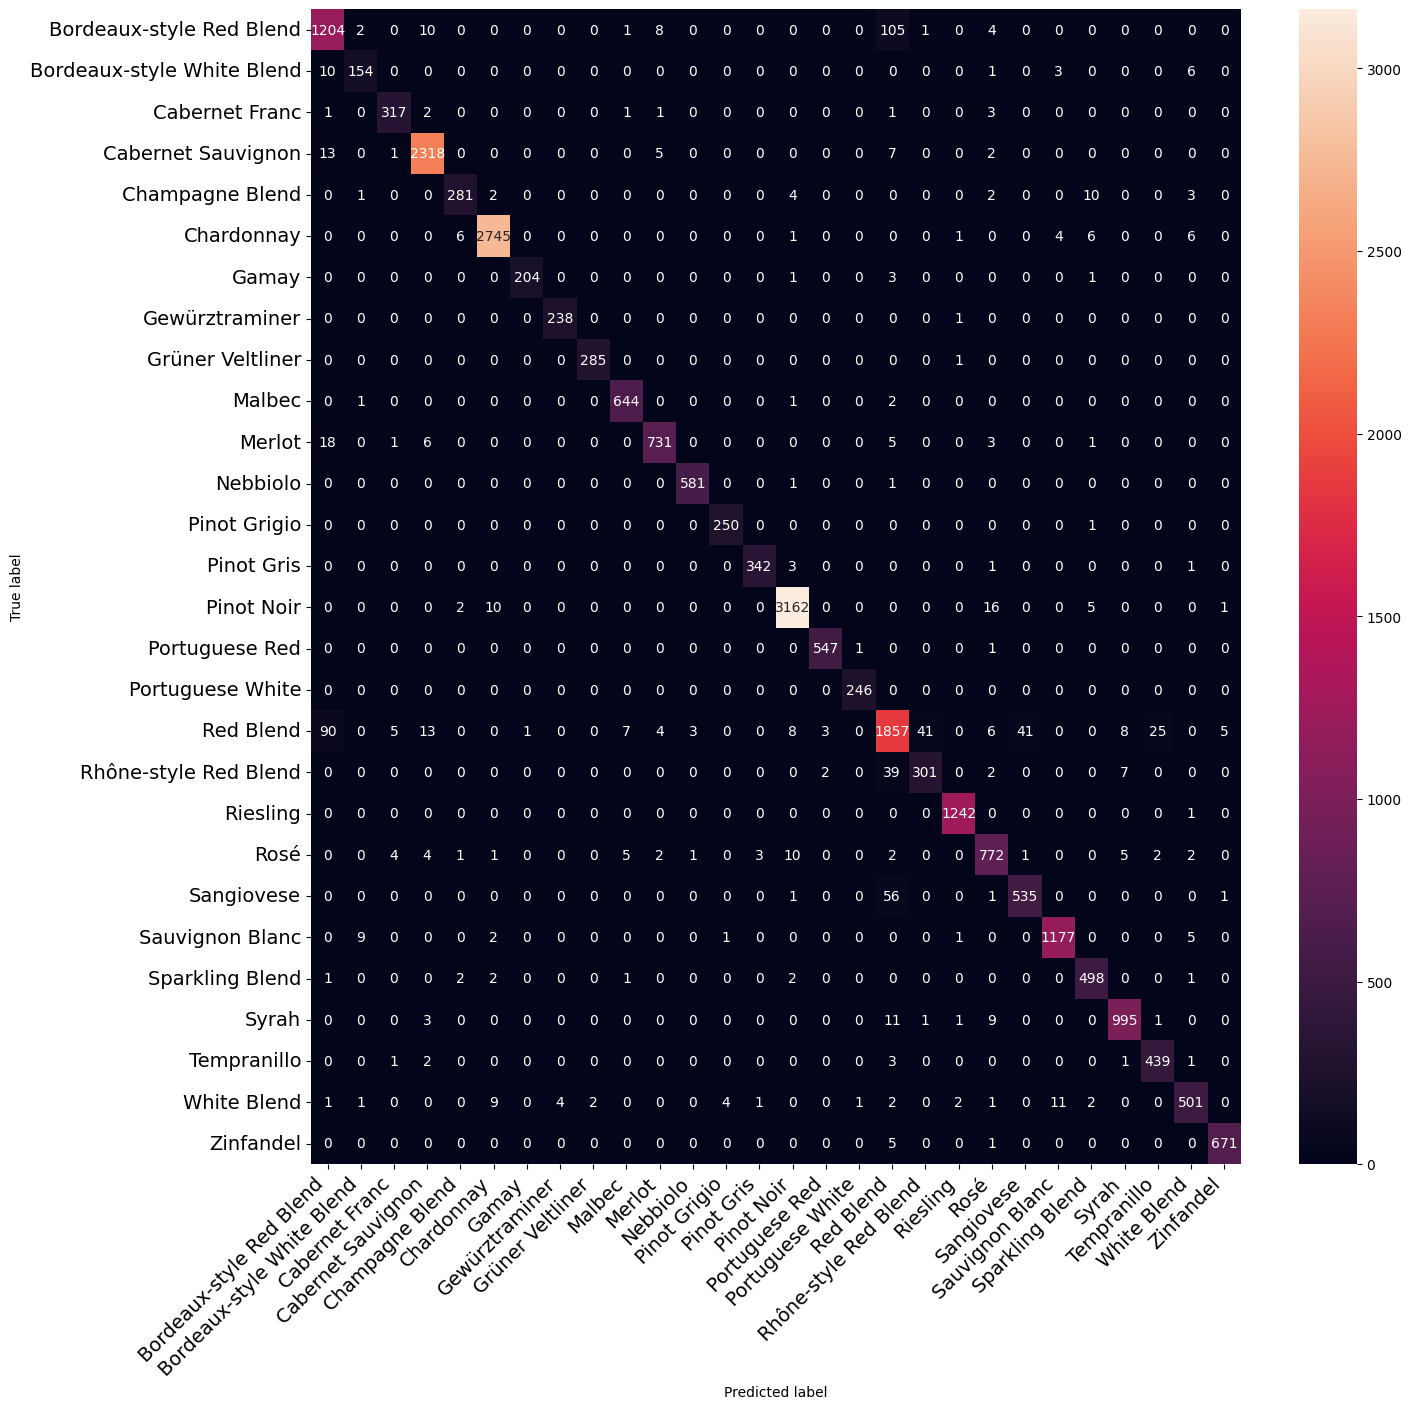

In [35]:
print_confusion_matrix(res, np.unique(Y));

Observed Validation Accuracy: 96%

## End notes:
- We used two models Random Forest gave 93% accuracy score and XG Boost gave 96% accuracy score with a promising confusion matrix.

- Our Accuracy can be further improved by using a better encoding techniques for the text document such as Elmo or Universal Sentence Encoders (USE).

- Oversampling and Undersampling all the categorical features to boost the learning of the model on categorical features containing very little saamples.